In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error, roc_auc_score
from catboost import CatBoostClassifier
import warnings
import gc
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
from sklearn import metrics
from functools import cmp_to_key
import logging
import xgboost as xgb

logging.basicConfig(filename='log.txt',level=logging.DEBUG, format='%(asctime)s %(message)s')

plt.style.use('seaborn')
sns.set(font_scale=1)
pd.set_option('display.max_columns', 500)
plt.subplots(figsize=(15,10))

%matplotlib inline

In [2]:
DATA_DIR = '/home/ryan/cs/datasets/microsoft'

In [3]:
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
len(dtypes)

83

In [5]:
%time train = pd.read_csv(join(DATA_DIR, 'train.csv'), dtype=dtypes)
%time test = pd.read_csv(join(DATA_DIR, 'test.csv'), dtype=dtypes)

CPU times: user 1min 12s, sys: 2.13 s, total: 1min 14s
Wall time: 1min 14s
CPU times: user 1min 6s, sys: 1.48 s, total: 1min 8s
Wall time: 1min 8s


In [6]:
labels = train['HasDetections']
# train = train.drop('HasDetections', axis=1)

In [7]:
if 5244810 in train.index:
    train.loc[5244810,'AvSigVersion'] = '1.273.1144.0'
    train['AvSigVersion'].cat.remove_categories('1.2&#x17;3.1144.0',inplace=True)

In [8]:
def condense_feature(df, col, category_map, fill_with=None):
    feature = df[col]
    reverse_map = {}
    default_val = None
    categories = feature.unique()
    categories = categories[~pd.isnull(categories)]
    
    for k, v_arr in category_map.items():
        if len(v_arr) != 0:
            for v in v_arr:       
                reverse_map[v] = k
                index = np.argwhere(categories==v)
                categories = np.delete(categories, index)         
        else:
            default_val = k
            
    for v in categories:
        reverse_map[v] = default_val
        
    condensed = df[col].map(reverse_map)
    if fill_with:
        condensed = condensed.fillna(fill_with)
    else:
        condensed = condensed.fillna(default_val)
    
    return condensed

def generate_count_feature(df, col, counts=None):
    if counts is None:
        feature = df[col]
        groups = df.groupby(col)
        counts = groups.size()
    count_feature = df[col].map(counts)
    
    return count_feature, counts

def group_battery(x):
    x = x.lower()
    if ('li' in x) or ('ion' in x):
        return 1
    else:
        return 0
    
def generate_freq_feature(df, col, on='HasDetections', frequencies=None):
#     print(frequencies)
    if frequencies is None:
        groups = df.groupby(col)
        sizes = groups.size()
        sums = groups.sum()[on]
        frequencies = sums/sizes
    freq_feature = df[col].map(frequencies)
    
    return freq_feature, frequencies

def generate_version_mapping(df, col, num_splits=4, fill_val='0.0.0.0'):
    feature = df[col].astype(str)
    feature.fillna(fill_val)
    versions = feature.unique()
    
    def version_compare(x, y):
        x_splits = x.split('.')
        y_splits = y.split('.')
        for x_val, y_val in zip(x_splits, y_splits):
            try:
                int_x = int(x_val)
            except:
                int_x = 0
            try:
                int_y = int(y_val)
            except:
                int_y = 0
            if int_x > int_y:
                return 1
            elif int_x < int_y:
                return -1
        return 0

    sorted_versions = sorted(versions, key=cmp_to_key(version_compare))
    mapping = {}
    for i, v in enumerate(sorted_versions):
        mapping[v] = i
        
    return feature.map(mapping)

def generate_split_version(df, col, num_splits=4):
    feature = df[col].astype(str)
    sv = pd.DataFrame()
    for i in range(num_splits):
        sv[col + '_' + str(i)] = feature.apply(lambda x: x.split('.')[i]).astype(int)
        
    return sv


In [9]:
def generate_count_df(df, cols, counts_map={}):
    count_df = pd.DataFrame()
    for col in cols:
        if col in counts_map:
            count_df[col + 'Counts'], _ = generate_count_feature(df, col, counts=counts_map[col])
        else:
            count_df[col + 'Counts'], counts_map[col] = generate_count_feature(df, col)
        
    return count_df, counts_map
        
def generate_freq_df(df, cols, freqs_map={}):
    freq_df = pd.DataFrame()
    for col in cols:
        if col in freqs_map:
            freq_df[col + 'Freqs'], _ = generate_freq_feature(df, col, frequencies=freqs_map[col])
        else:
            freq_df[col + 'Freqs'],  freqs_map[col] =  generate_freq_feature(df, col)
            
    return freq_df, freqs_map

def generate_category_df(df, cols):
    cat_df = pd.DataFrame()
    for col in cols:
        cat_df[col+'Cat'] = df[col].astype('category')
        
    return cat_df
        
def generate_boolean_df(df, cols):
    bool_df = pd.DataFrame()
    for col in cols:
        bool_df[col+'Bool'] = df[col].astype(np.bool)
        
    return bool_df
        
def generate_gb_df(df, cols):
    gb_df = pd.DataFrame()
    for col in cols:
        gb_df[col+'GB'] = df[col].fillna(df[col].median()).apply(lambda x: int(x/1000))
        
    return gb_df

In [10]:
import category_encoders as ce

In [27]:
def feature_engineer(df, frequencies_map={}, counts_map={}):

    # mine
    fe = pd.DataFrame()
    
    
    fe['MoreThanOneAV'] = condense_feature(df, 'AVProductsInstalled', {0: [0.0, 1.0], 1: []}, fill_with=0).astype(np.int8)
    
    fe['AVProductsEnabled'] = df['AVProductsEnabled'].fillna(0.0).astype(np.int8)

    
    sku_feature = condense_feature(df, 'SkuEdition', {'Home': ['Home'], 'Pro': ['Pro'], 'SkuEtc':[]})
    fe['SkuCondensed'] = sku_feature.astype('category')
    
    fe['IsProtected'] = df['IsProtected'].astype(np.bool)
    
    fe['SmartScreen'] = condense_feature(df, 'SmartScreen', 
                                            {True: ['RequireAdmin', 'On', 'Warn', 'on', 'Enabled', 'warn', 'Block', 'Prompt', 'Promp', 'requireadmin', 'prompt', 'requireAdmin'], 
                                             False: []}).astype(np.bool)
    
    
    
    fe['CountryIdentifier'] = df['CountryIdentifier'].astype('category')
    
    fe['EngineVersionMapped'] = generate_version_mapping(df, 'EngineVersion')
    fe = fe.join(generate_split_version(df, 'EngineVersion'))
    
    fe['AppVersionMapped'] = generate_version_mapping(df, 'AppVersion')
    fe = fe.join(generate_split_version(df, 'AppVersion'))
    
    fe['IeVerIdentifier'] = df['IeVerIdentifier'].fillna(0.0).astype(np.int16)
    
    fe['ProcessorCoreCount'] = df['Census_ProcessorCoreCount'].fillna(4.0).astype(np.int8)
    
    fe['Census_ProcessorModelIdentifier'] = df['Census_ProcessorModelIdentifier'].fillna(0.0).astype(np.int16)
    
    fe['Census_InternalPrimaryDiagonalDisplaySizeInInches'] = df['Census_InternalPrimaryDiagonalDisplaySizeInInches']
    
    fe['BatteryType'] = df['Census_InternalBatteryType'].apply(group_battery)
    
    fe['BatteryNumberOfCharges'] = df['Census_InternalBatteryNumberOfCharges'].fillna(df['Census_InternalBatteryNumberOfCharges'].median()).astype(np.int8)
    
    fe['AvSigVersionMapped'] = generate_version_mapping(df, 'AvSigVersion')
    fe = fe.join(generate_split_version(df, 'AvSigVersion'))
    
    count_cols = ['Platform', 'EngineVersion', 'AppVersion', 'AvSigVersion', 'AVProductStatesIdentifier',
                  'CountryIdentifier', 'Census_OSVersion', 'CityIdentifier', 'OrganizationIdentifier', 'Processor',
                  'IeVerIdentifier', 'Census_MDC2FormFactor', 'OsBuild', 'Census_ChassisTypeName', 'Census_PowerPlatformRoleName',
                   'Census_OSBranch', 'Census_OSBuildNumber', 'Census_OSBuildRevision',
                  'Census_OSEdition', 'Census_OSInstallTypeName', 'Census_ActivationChannel',
                  'Census_FirmwareVersionIdentifier', 'Census_IsTouchEnabled', 'Census_OSUILocaleIdentifier']
    
    freq_cols = ['OrganizationIdentifier', 'CountryIdentifier', 'IeVerIdentifier', 
                 'Census_ActivationChannel', 'Census_FirmwareManufacturerIdentifier', 'Census_OSUILocaleIdentifier']
    
    category_cols = ['AVProductsInstalled','LocaleEnglishNameIdentifier', 'Platform', 'Processor', 'OsBuild', 'OsSuite',
                     'OsPlatformSubRelease', 'IeVerIdentifier', 'Census_MDC2FormFactor', 
                     'Census_ProcessorCoreCount', 'Census_ProcessorManufacturerIdentifier',
                     'Census_PrimaryDiskTypeName', 'Census_ChassisTypeName', 'Census_PowerPlatformRoleName',
                     'Census_OSBranch', 'Census_OSInstallTypeName',
                     'Census_OSWUAutoUpdateOptionsName', 'Census_ActivationChannel', 'Census_FlightRing',
                     'Wdft_RegionIdentifier']
    
    gb_cols = ['Census_PrimaryDiskTotalCapacity', 'Census_SystemVolumeTotalCapacity', 'Census_TotalPhysicalRAM']
    
    boolean_cols = ['IsProtected', 'SMode', 'Firewall', 
                    'Census_HasOpticalDiskDrive', 'Census_GenuineStateName', 'Census_IsSecureBootEnabled', 
                    'Census_IsTouchEnabled', 'Census_IsPenCapable', 'Census_IsAlwaysOnAlwaysConnectedCapable',
                    'Wdft_IsGamer']
    
    
    
    count_df, counts_map = generate_count_df(df, count_cols, counts_map=counts_map)

    freq_df, frequencies_map = generate_freq_df(df, freq_cols, freqs_map=frequencies_map)
    
    fe = fe.join(count_df)

    fe = fe.join(freq_df)
    fe = fe.join(generate_category_df(df, category_cols))
    fe = fe.join(generate_gb_df(df, gb_cols))
    fe = fe.join(generate_boolean_df(df, boolean_cols))
    
    # importance from lgb_kernel
    
    fe['OSVerOrdinal'] = generate_version_mapping(df, 'Census_OSVersion')
    fe['CountryIdentifier'] = df['CountryIdentifier']
    
#     ce_hash = ce.HashingEncoder(cols=['GeoNameIdentifier'])
#     ce_hash.fit(df, labels)
#     new_dat = ce_hash.transform(df)
#     fe = fe.join(new_dat)

    # important feature
    fe['GeoName'] = df['GeoNameIdentifier'].astype('category')
    
    fe['OSBuildRevision'] = df['Census_OSBuildRevision'].astype('category')
    fe['OSBuildLab'] = df['OsBuildLab'].astype('category')
    
    fe['FirmwareManufacturer'] = df['Census_FirmwareManufacturerIdentifier'].astype('category')
    fe['AppVersion'] = df['AppVersion']
    fe['AVProductStatesIdentifier'] = df['AVProductStatesIdentifier'].astype('category')
    
    fe['OSVersion_0'] = df['Census_OSVersion'].apply(lambda x: x.split('.')[0]).astype('category')
    fe['OSVersion_1'] = df['Census_OSVersion'].apply(lambda x: x.split('.')[1]).astype('category')
    fe['OSVersion_2'] = df['Census_OSVersion'].apply(lambda x: x.split('.')[2]).astype('category')
    fe['OSVersion_3'] = df['Census_OSVersion'].apply(lambda x: x.split('.')[3]).astype('category')
    fe['AvSigVersion_1'] = df['AvSigVersion'].apply(lambda x: x.split('.')[1]).astype('category')
    fe['EngineVersion'] = df['EngineVersion'].astype('category')
    fe['Census_OSInstallTypeName'] = df['Census_OSInstallTypeName'].astype('category')
    
    
    
    return fe, frequencies_map, counts_map

In [28]:
print('Feature engineering train features...')
train_l1, freqs, counts = feature_engineer(train)
print('Feature engineering test features...')
test_l1, _, _ = feature_engineer(test, frequencies_map=freqs, counts_map=counts)
# test_l1 = train_l1

Feature engineering train features...
Feature engineering test features...


In [29]:
test_l1.head()

,MoreThanOneAV,AVProductsEnabled,Home,Pro,SkuEtc,IsProtected,SmartScreen,CountryIdentifier,EngineVersionMapped,EngineVersion_0,EngineVersion_1,EngineVersion_2,EngineVersion_3,AppVersionMapped,AppVersion_0,AppVersion_1,AppVersion_2,AppVersion_3,IeVerIdentifier,ProcessorCoreCount,Census_ProcessorModelIdentifier,Census_InternalPrimaryDiagonalDisplaySizeInInches,BatteryType,BatteryNumberOfCharges,PlatformCounts,EngineVersionCounts,AppVersionCounts,AvSigVersionCounts,AVProductStatesIdentifierCounts,CountryIdentifierCounts,Census_OSVersionCounts,CityIdentifierCounts,OrganizationIdentifierCounts,ProcessorCounts,IeVerIdentifierCounts,Census_MDC2FormFactorCounts,OsBuildCounts,Census_ChassisTypeNameCounts,Census_PowerPlatformRoleNameCounts,Census_OSArchitectureCounts,Census_OSBranchCounts,Census_OSBuildNumberCounts,Census_OSBuildRevisionCounts,Census_OSEditionCounts,Census_OSSkuNameCounts,Census_OSInstallTypeNameCounts,Census_ActivationChannelCounts,Census_FirmwareVersionIdentifierCounts,Census_IsTouchEnabledCounts,Census_OSUILocaleIdentifierCounts,OrganizationIdentifierFreqs,CountryIdentifierFreqs,IeVerIdentifierFreqs,Census_OSInstallLanguageIdentifierFreqs,Census_ActivationChannelFreqs,Census_FirmwareManufacturerIdentifierFreqs,Census_OSUILocaleIdentifierFreqs,LocaleEnglishNameIdentifierCat,PlatformCat,ProcessorCat,OsVerCat,OsBuildCat,OsSuiteCat,OsPlatformSubReleaseCat,IeVerIdentifierCat,Census_MDC2FormFactorCat,Census_DeviceFamilyCat,Census_ProcessorCoreCountCat,Census_ProcessorManufacturerIdentifierCat,Census_PrimaryDiskTypeNameCat,Census_ChassisTypeNameCat,Census_PowerPlatformRoleNameCat,Census_OSArchitectureCat,Census_OSBranchCat,Census_OSInstallTypeNameCat,Census_OSInstallLanguageIdentifierCat,Census_OSWUAutoUpdateOptionsNameCat,Census_ActivationChannelCat,Census_FlightRingCat,Wdft_RegionIdentifierCat,Census_PrimaryDiskTotalCapacityGB,Census_SystemVolumeTotalCapacityGB,Census_TotalPhysicalRAMGB,IsProtectedBool,HasTpmBool,AutoSampleOptInBool,SModeBool,FirewallBool,UacLuaenableBool,Census_HasOpticalDiskDriveBool,Census_GenuineStateNameBool,Census_IsSecureBootEnabledBool,Census_IsTouchEnabledBool,Census_IsPenCapableBool,Census_IsAlwaysOnAlwaysConnectedCapableBool,Wdft_IsGamerBool,OSVerOrdinal,GeoName,OSBuildRevision,OSBuildLab,FirmwareManufacturer,AppVersion,AVProductStatesIdentifier,OSVersion_0,OSVersion_1,OSVersion_2,OSVersion_3,EngineVersion,Census_OSInstallTypeName
0,0,1,1,0,0,True,False,43,69,1,1,15400,5,115,4,18,1810,5,108,4,3064,15.500000,0,8,8618715,NaN,NaN,NaN,5824565.0,397172,NaN,6469.0,1764175.0,346,474390.0,5723319.0,780270.0,5248812.0,6182908.0,8105885,797066.0,797049.0,NaN,3469991.0,3469869.0,649201,3413350,223.0,7801452,408118.0,0.505705,0.512030,0.476410,0.517064,0.496623,0.475365,0.517929,42,windows10,x64,10.0.0.0,15063,768,rs2,108.0,Notebook,Windows.Desktop,4.0,5.0,SSD,Notebook,Mobile,amd64,rs2_release,Reset,37.0,AutoInstallAndRebootAtMaintenanceTime,OEM:DM,Retail,7.0,488,123,8,True,True,False,True,True,True,False,True,True,False,False,False,False,300,53.0,1387,15063.0.amd64fre.rs2_release.170317-1834,807.0,4.18.1810.5,53447.0,10,0,15063,1387,1.1.15400.5,Reset
1,0,1,1,0,0,True,True,68,68,1,1,15400,4,113,4,18,1809,2,117,4,3410,15.500000,0,0,8618715,NaN,13739.0,NaN,5824565.0,160158,216776.0,262.0,NaN,346,1767931.0,5723319.0,2503681.0,5248812.0,6182908.0,8105885,1199767.0,2443249.0,216776.0,3469991.0,3469869.0,2608037,4727589,89611.0,7801452,513995.0,NaN,0.479183,0.493868,0.485926,0.491946,0.510175,0.485310,74,windows10,x64,10.0.0.0,16299,768,rs3,117.0,Notebook,Windows.Desktop,4.0,5.0,HDD,Notebook,Mobile,amd64,rs3_release_svc_escrow,UUPUpgrade,7.0,AutoInstallAndRebootAtMaintenanceTime,Retail,Retail,12.0,1907,1882,8,True,True,False,True,True,True,False,True,True,False,False,False,True,343,276.0,611,16299.431.amd64fre.rs3_release_svc_escrow.1805...,554.0,4.18.1809.2,53447.0,10,0,16299,611,1.1.15400.4,UUPUpgrade
2,1,1,1,0,0,True,True,201,66,1,1,15300,6,113,4,18,1809,2,98,2,2096,13.898438,0,0,8618715,120295.0,13739.0,NaN,

In [30]:
# params from https://www.kaggle.com/fabiendaniel/detecting-malwares-with-lgbm
params = {'num_leaves': 256,
         'min_data_in_leaf': 42,
         'objective': 'binary',
         'max_depth': -1,
         'learning_rate': 0.05,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 5,
         "bagging_fraction": 0.8,
         "bagging_seed": 11,
         "lambda_l1": 0.15,
         "lambda_l2": 0.15,
         "random_state": 42,          
         "verbosity": -1}
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=15)

In [31]:
from numba import jit
# fast roc_auc computation: https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76013
@jit
def fast_auc(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc

def eval_auc(preds, dtrain):
    labels = dtrain.get_label()
    return 'auc', fast_auc(labels, preds), True

# idea from this kernel: https://www.kaggle.com/fabiendaniel/detecting-malwares-with-lgbm
def predict_chunk(model, test):
    initial_idx = 0
    chunk_size = 1000000
    current_pred = np.zeros(len(test))
    while initial_idx < test.shape[0]:
        final_idx = min(initial_idx + chunk_size, test.shape[0])
        idx = range(initial_idx, final_idx)
        current_pred[idx] = model.predict(test.iloc[idx], num_iteration=model.best_iteration)
        initial_idx = final_idx
    #predictions += current_pred / min(folds.n_splits, max_iter)
    return current_pred


def train_model(X, X_test, y, params=None, folds=folds, model_type='lgb', plot_feature_importance=False, averaging='usual', make_oof=False):
    result_dict = {}
    if make_oof:
        oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        gc.collect()
        print('Fold', fold_n + 1, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        
        if model_type == 'lgb':
            train_data = lgb.Dataset(X_train, label=y_train)
            valid_data = lgb.Dataset(X_valid, label=y_valid)
            
            model = lgb.train(params,
                    train_data,
                    num_boost_round=2000,
                    valid_sets = [train_data, valid_data],
                    verbose_eval=500,
                    early_stopping_rounds = 200,
                    feval=eval_auc)

            del train_data, valid_data
            
            y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
            del X_valid
            gc.collect()
            # print('predicting on test')
            # y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            y_pred = predict_chunk(model, X_test)
            # print('predicted')
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid), ntree_limit=model.best_ntree_limit)
            #y_pred = model.predict(xgb.DMatrix(X_test), ntree_limit=model.best_ntree_limit)
            y_pred = predict_chunk(model, xgb.DMatrix(X_test))
            
        if model_type == 'lcv':
            model = LogisticRegressionCV(scoring='roc_auc', cv=3)
            model.fit(X_train, y_train)

            y_pred_valid = model.predict(X_valid)
            # y_pred = model.predict(X_test)
            y_pred = predict_chunk(model, X_test)
            
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='AUC', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            # y_pred = model.predict(X_test)
            y_pred = predict_chunk(model, X_test)
        
        if make_oof:
            oof[valid_index] = y_pred_valid.reshape(-1,)
            
        scores.append(fast_auc(y_valid, y_pred_valid))
        print('Fold roc_auc:', roc_auc_score(y_valid, y_pred_valid))
        print('')
        
        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importance()
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        
        if plot_feature_importance:
            feature_importance["importance"] /= n_fold
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]
            logging.info('Top features')
            for f in best_features.sort_values(by="importance", ascending=False)['feature'].values:
                logging.info(f)

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
            
    result_dict['prediction'] = prediction
    if make_oof:
        result_dict['oof'] = oof
    
    return result_dict

Fold 1 started at Mon Feb 25 19:28:24 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's binary_logloss: 0.591442	training's auc: 0.748815	valid_1's binary_logloss: 0.611347	valid_1's auc: 0.722361
Early stopping, best iteration is:
[724]	training's binary_logloss: 0.586122	training's auc: 0.755421	valid_1's binary_logloss: 0.611116	valid_1's auc: 0.722631
Fold roc_auc: 0.722631871377

Fold 2 started at Mon Feb 25 20:23:40 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's binary_logloss: 0.591715	training's auc: 0.74853	valid_1's binary_logloss: 0.611331	valid_1's auc: 0.722345
[1000]	training's binary_logloss: 0.580749	training's auc: 0.762109	valid_1's binary_logloss: 0.611121	valid_1's auc: 0.722681
Early stopping, best iteration is:
[848]	training's binary_logloss: 0.583582	training's auc: 0.758627	valid_1's binary_logloss: 0.611013	valid_1's auc: 0.722785
Fold roc_auc: 0.722784609752

Fold 3 started at Mon Feb 25

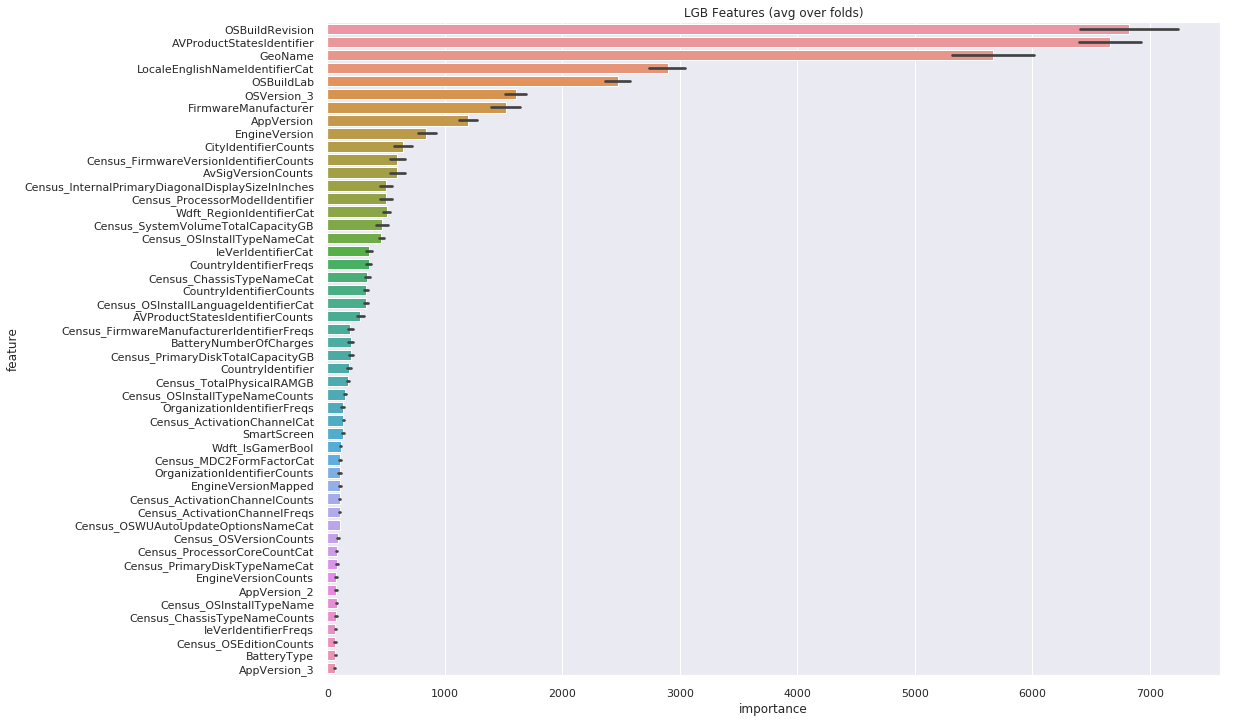

In [39]:
result_dict1 = train_model(X=train_l1, X_test=test_l1, y=labels, params=params, model_type='lgb', plot_feature_importance=True, averaging='usual')

In [40]:
result_dict1['feature_importance']

,feature,importance,fold
0,MoreThanOneAV,29.8,1
1,AVProductsEnabled,26.2,1
2,Home,43.2,1
3,Pro,24.8,1
4,SkuEtc,9.0,1
5,IsProtected,10.2,1
6,SmartScreen,142.4,1
7,CountryIdentifier,161.0,1
8,EngineVersionMapped,99.0,1
9,EngineVersion_0,0.0,1


In [41]:
submission = pd.read_csv('/home/ryan/cs/datasets/microsoft/sample_submission.csv')
submission['HasDetections'] = result_dict1['prediction']
submission.to_csv('v1.csv', index=False)

In [42]:
result_dict1.keys()

dict_keys(['prediction', 'feature_importance'])

In [43]:
test_l1.head()

,MoreThanOneAV,AVProductsEnabled,Home,Pro,SkuEtc,IsProtected,SmartScreen,CountryIdentifier,EngineVersionMapped,EngineVersion_0,EngineVersion_1,EngineVersion_2,EngineVersion_3,AppVersionMapped,AppVersion_0,AppVersion_1,AppVersion_2,AppVersion_3,IeVerIdentifier,ProcessorCoreCount,Census_ProcessorModelIdentifier,Census_InternalPrimaryDiagonalDisplaySizeInInches,BatteryType,BatteryNumberOfCharges,PlatformCounts,EngineVersionCounts,AppVersionCounts,AvSigVersionCounts,AVProductStatesIdentifierCounts,CountryIdentifierCounts,Census_OSVersionCounts,CityIdentifierCounts,OrganizationIdentifierCounts,ProcessorCounts,IeVerIdentifierCounts,Census_MDC2FormFactorCounts,OsBuildCounts,Census_ChassisTypeNameCounts,Census_PowerPlatformRoleNameCounts,Census_OSArchitectureCounts,Census_OSBranchCounts,Census_OSBuildNumberCounts,Census_OSBuildRevisionCounts,Census_OSEditionCounts,Census_OSSkuNameCounts,Census_OSInstallTypeNameCounts,Census_ActivationChannelCounts,Census_FirmwareVersionIdentifierCounts,Census_IsTouchEnabledCounts,Census_OSUILocaleIdentifierCounts,OrganizationIdentifierFreqs,CountryIdentifierFreqs,IeVerIdentifierFreqs,Census_OSInstallLanguageIdentifierFreqs,Census_ActivationChannelFreqs,Census_FirmwareManufacturerIdentifierFreqs,Census_OSUILocaleIdentifierFreqs,LocaleEnglishNameIdentifierCat,PlatformCat,ProcessorCat,OsVerCat,OsBuildCat,OsSuiteCat,OsPlatformSubReleaseCat,IeVerIdentifierCat,Census_MDC2FormFactorCat,Census_DeviceFamilyCat,Census_ProcessorCoreCountCat,Census_ProcessorManufacturerIdentifierCat,Census_PrimaryDiskTypeNameCat,Census_ChassisTypeNameCat,Census_PowerPlatformRoleNameCat,Census_OSArchitectureCat,Census_OSBranchCat,Census_OSInstallTypeNameCat,Census_OSInstallLanguageIdentifierCat,Census_OSWUAutoUpdateOptionsNameCat,Census_ActivationChannelCat,Census_FlightRingCat,Wdft_RegionIdentifierCat,Census_PrimaryDiskTotalCapacityGB,Census_SystemVolumeTotalCapacityGB,Census_TotalPhysicalRAMGB,IsProtectedBool,HasTpmBool,AutoSampleOptInBool,SModeBool,FirewallBool,UacLuaenableBool,Census_HasOpticalDiskDriveBool,Census_GenuineStateNameBool,Census_IsSecureBootEnabledBool,Census_IsTouchEnabledBool,Census_IsPenCapableBool,Census_IsAlwaysOnAlwaysConnectedCapableBool,Wdft_IsGamerBool,OSVerOrdinal,GeoName,OSBuildRevision,OSBuildLab,FirmwareManufacturer,AppVersion,AVProductStatesIdentifier,OSVersion_0,OSVersion_1,OSVersion_2,OSVersion_3,EngineVersion,Census_OSInstallTypeName
0,0,1,1,0,0,True,False,43,69,1,1,15400,5,115,4,18,1810,5,108,4,3064,15.500000,0,8,8618715,NaN,NaN,NaN,5824565.0,397172,NaN,6469.0,1764175.0,346,474390.0,5723319.0,780270.0,5248812.0,6182908.0,8105885,797066.0,797049.0,NaN,3469991.0,3469869.0,649201,3413350,223.0,7801452,408118.0,0.505705,0.512030,0.476410,0.517064,0.496623,0.475365,0.517929,42,windows10,x64,10.0.0.0,15063,768,rs2,108.0,Notebook,Windows.Desktop,4.0,5.0,SSD,Notebook,Mobile,amd64,rs2_release,Reset,37.0,AutoInstallAndRebootAtMaintenanceTime,OEM:DM,Retail,7.0,488,123,8,True,True,False,True,True,True,False,True,True,False,False,False,False,300,53.0,1387,15063.0.amd64fre.rs2_release.170317-1834,807.0,4.18.1810.5,53447.0,10,0,15063,1387,1.1.15400.5,Reset
1,0,1,1,0,0,True,True,68,68,1,1,15400,4,113,4,18,1809,2,117,4,3410,15.500000,0,0,8618715,NaN,13739.0,NaN,5824565.0,160158,216776.0,262.0,NaN,346,1767931.0,5723319.0,2503681.0,5248812.0,6182908.0,8105885,1199767.0,2443249.0,216776.0,3469991.0,3469869.0,2608037,4727589,89611.0,7801452,513995.0,NaN,0.479183,0.493868,0.485926,0.491946,0.510175,0.485310,74,windows10,x64,10.0.0.0,16299,768,rs3,117.0,Notebook,Windows.Desktop,4.0,5.0,HDD,Notebook,Mobile,amd64,rs3_release_svc_escrow,UUPUpgrade,7.0,AutoInstallAndRebootAtMaintenanceTime,Retail,Retail,12.0,1907,1882,8,True,True,False,True,True,True,False,True,True,False,False,False,True,343,276.0,611,16299.431.amd64fre.rs3_release_svc_escrow.1805...,554.0,4.18.1809.2,53447.0,10,0,16299,611,1.1.15400.4,UUPUpgrade
2,1,1,1,0,0,True,True,201,66,1,1,15300,6,113,4,18,1809,2,98,2,2096,13.898438,0,0,8618715,120295.0,13739.0,NaN,

In [44]:
train_l1.head()

,MoreThanOneAV,AVProductsEnabled,Home,Pro,SkuEtc,IsProtected,SmartScreen,CountryIdentifier,EngineVersionMapped,EngineVersion_0,EngineVersion_1,EngineVersion_2,EngineVersion_3,AppVersionMapped,AppVersion_0,AppVersion_1,AppVersion_2,AppVersion_3,IeVerIdentifier,ProcessorCoreCount,Census_ProcessorModelIdentifier,Census_InternalPrimaryDiagonalDisplaySizeInInches,BatteryType,BatteryNumberOfCharges,PlatformCounts,EngineVersionCounts,AppVersionCounts,AvSigVersionCounts,AVProductStatesIdentifierCounts,CountryIdentifierCounts,Census_OSVersionCounts,CityIdentifierCounts,OrganizationIdentifierCounts,ProcessorCounts,IeVerIdentifierCounts,Census_MDC2FormFactorCounts,OsBuildCounts,Census_ChassisTypeNameCounts,Census_PowerPlatformRoleNameCounts,Census_OSArchitectureCounts,Census_OSBranchCounts,Census_OSBuildNumberCounts,Census_OSBuildRevisionCounts,Census_OSEditionCounts,Census_OSSkuNameCounts,Census_OSInstallTypeNameCounts,Census_ActivationChannelCounts,Census_FirmwareVersionIdentifierCounts,Census_IsTouchEnabledCounts,Census_OSUILocaleIdentifierCounts,OrganizationIdentifierFreqs,CountryIdentifierFreqs,IeVerIdentifierFreqs,Census_OSInstallLanguageIdentifierFreqs,Census_ActivationChannelFreqs,Census_FirmwareManufacturerIdentifierFreqs,Census_OSUILocaleIdentifierFreqs,LocaleEnglishNameIdentifierCat,PlatformCat,ProcessorCat,OsVerCat,OsBuildCat,OsSuiteCat,OsPlatformSubReleaseCat,IeVerIdentifierCat,Census_MDC2FormFactorCat,Census_DeviceFamilyCat,Census_ProcessorCoreCountCat,Census_ProcessorManufacturerIdentifierCat,Census_PrimaryDiskTypeNameCat,Census_ChassisTypeNameCat,Census_PowerPlatformRoleNameCat,Census_OSArchitectureCat,Census_OSBranchCat,Census_OSInstallTypeNameCat,Census_OSInstallLanguageIdentifierCat,Census_OSWUAutoUpdateOptionsNameCat,Census_ActivationChannelCat,Census_FlightRingCat,Wdft_RegionIdentifierCat,Census_PrimaryDiskTotalCapacityGB,Census_SystemVolumeTotalCapacityGB,Census_TotalPhysicalRAMGB,IsProtectedBool,HasTpmBool,AutoSampleOptInBool,SModeBool,FirewallBool,UacLuaenableBool,Census_HasOpticalDiskDriveBool,Census_GenuineStateNameBool,Census_IsSecureBootEnabledBool,Census_IsTouchEnabledBool,Census_IsPenCapableBool,Census_IsAlwaysOnAlwaysConnectedCapableBool,Wdft_IsGamerBool,OSVerOrdinal,GeoName,OSBuildRevision,OSBuildLab,FirmwareManufacturer,AppVersion,AVProductStatesIdentifier,OSVersion_0,OSVersion_1,OSVersion_2,OSVersion_3,EngineVersion,Census_OSInstallTypeName
0,0,1,0,1,0,True,False,29,66,1,1,15100,1,107,4,18,1807,18075,137,4,2340,18.906250,0,0,8618715,3675915,5139224,19193,5824565.0,347991,899711,6261.0,1764175.0,8105435,3885842.0,1951086,3915521,1872125.0,2066620.0,8105885,4009158,4008881,899712,3130566,3187913,2608037,4727589,455.0,7801452,337988,0.505705,0.505318,0.52082,0.508893,0.491946,0.501592,0.508882,-85,windows10,x64,10.0.0.0,17134,256,rs4,137.0,Desktop,Windows.Desktop,4.0,5.0,HDD,Desktop,Desktop,amd64,rs4_release,UUPUpgrade,26.0,UNKNOWN,Retail,Retail,10.0,476,299,4,True,True,False,False,True,True,False,True,False,False,False,False,False,383,35.0,165,17134.1.amd64fre.rs4_release.180410-1804,628.0,4.18.1807.18075,53447.0,10,0,17134,165,1.1.15100.1,UUPUpgrade
1,0,1,0,1,0,True,False,93,56,1,1,14600,4,74,4,13,17134,1,137,4,2404,13.898438,0,1,8618715,160585,257270,98024,5824565.0,283625,100759,7913.0,1764175.0,8105435,3885842.0,5723319,3915521,5248812.0,6182908.0,8105885,4009158,4008881,106583,3130566,3187913,1650733,4727589,693.0,7801452,3170824,0.505705,0.492203,0.52082,0.507091,0.491946,0.501592,0.506770,64,windows10,x64,10.0.0.0,17134,256,rs4,137.0,Notebook,Windows.Desktop,4.0,5.0,HDD,Notebook,Mobile,amd64,rs4_release,IBSClean,8.0,UNKNOWN,Retail,NOT_SET,8.0,476,102,4,True,True,False,False,True,True,False,True,False,False,False,False,False,375,119.0,1,17134.1.amd64fre.rs4_release.180410-1804,628.0,4.13.17134.1,53447.0,10,0,17134,1,1.1.14600.4,IBSClean
2,0,1,1,0,0,True,True,86,66,1,1,15100,1,107,4,18,1807,18075,137,4,1972,21.500000,0,0,8618715,3675915,5139224,10051,5824565.0,41214,899711,1820.0,1764175.0,8105435,388

In [45]:
submission.head()

,MachineIdentifier,HasDetections
0,0000010489e3af074adeac69c53e555e,0.481613
1,00000176ac758d54827acd545b6315a5,0.347183
2,0000019dcefc128c2d4387c1273dae1d,0.344455
3,0000055553dc51b1295785415f1a224d,0.315052
4,00000574cefffeca83ec8adf9285b2bf,0.382520
